In [1]:
import copy
import json
import os

from fastcluster import linkage
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

In [2]:
def read_jsonl(path):
    """Parse jsonl to list of dicts"""
    with open(path) as f:
        lines = f.readlines()
    return [json.loads(line) for line in lines]


def get_signatures(ap_results):
    """Given the author profile results get all signatures"""
    signatures = []
    for profile in ap_results:
        signatures += profile['signatureIds']
    return signatures


def fill_dmatrix(distances, signature_list):
    """Given distances jsonl and list of signatures fill the distance matrix"""
    dmatrix = np.zeros(shape=(len(signature_list), len(signature_list)))

    signature_to_idx = {
        signature: idx for idx, signature in enumerate(signature_list)
    }

    for distance in distances:
        sig1 = distance['signatureId1']
        sig2 = distance['signatureId2']
        d = distance['distance']
        row = signature_to_idx[sig1]
        column = signature_to_idx[sig2]
        dmatrix[row, column] = d

    dmatrix = dmatrix.T + dmatrix # Transpose to fill symetric elements
    return dmatrix, signature_to_idx


def get_features(sig_id, features):
    """Retrieve all feature vectors realated to the given signature"""
    feature_vectors = []
    for feature_entry in features:
        if feature_entry['signatureId1'] == sig_id or feature_entry['signatureId2'] == sig_id:
            feature_vectors.append(feature_entry['features'])
    return feature_vectors

In [3]:
AUTHOR_PATH = '../data/cmavergames/'

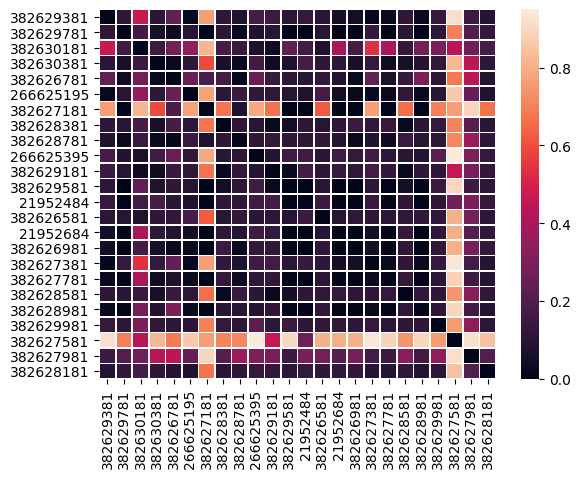

In [4]:
ap_results = read_jsonl(path=os.path.join(AUTHOR_PATH, 'results.json'))
distances = read_jsonl(path=os.path.join(AUTHOR_PATH, 'distances.json'))
signatures = get_signatures(ap_results)
dmatrix, signature_to_idx = fill_dmatrix(distances, signatures)

sns.heatmap(dmatrix, linewidths=0.5, xticklabels=signatures, yticklabels=signatures)
plt.show()

In [5]:
clusterer = AgglomerativeClustering(
                n_clusters=None,
                affinity='precomputed',
                distance_threshold=0.52502,
                linkage='average'
)
profiles = clusterer.fit_predict(dmatrix)
print(f'Created {len(np.unique(profiles))} profiles')

Created 2 profiles


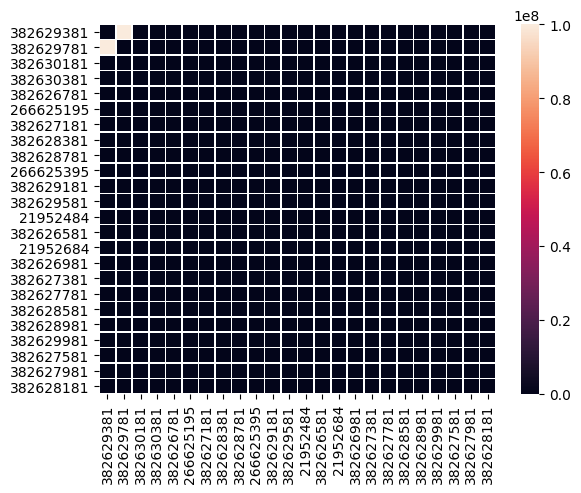

Created 3 profiles


In [6]:
modified_matrix = copy.deepcopy(dmatrix)
modified_matrix[0, 1] = 100_000_000
modified_matrix[1, 0] = 100_000_000
# Setting to np.inf throws the error: ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

sns.heatmap(modified_matrix, linewidths=0.5, xticklabels=signatures, yticklabels=signatures)
plt.show()

clusterer = AgglomerativeClustering(
                n_clusters=None,
                affinity='precomputed',
                distance_threshold=0.52502,
                linkage='average'
)
profiles = clusterer.fit_predict(modified_matrix)
print(f'Created {len(np.unique(profiles))} profiles')

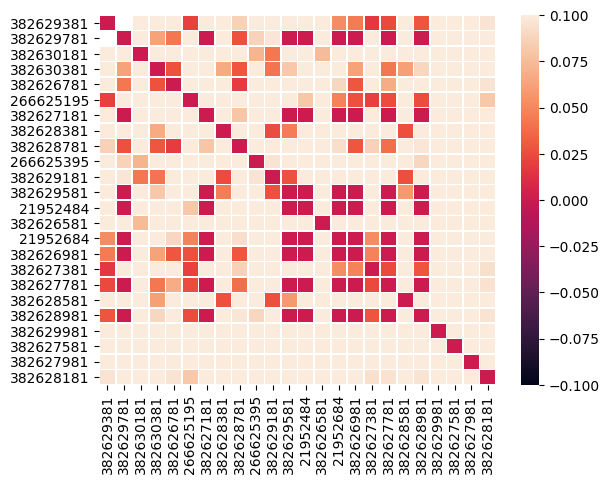

Created 3 profiles


In [7]:
modified_matrix = copy.deepcopy(dmatrix)
modified_matrix[0, 1] = np.inf
modified_matrix[1, 0] = np.inf
condensed_dmatrix = modified_matrix[np.triu_indices(n=modified_matrix.shape[0], k=1)]

sns.heatmap(modified_matrix, linewidths=0.5, xticklabels=signatures, yticklabels=signatures)
plt.show()

Z = linkage(condensed_dmatrix, method='average')
fastcluster_profiles = fcluster(Z, t=0.52502, criterion='distance')

print(f'Created {len(np.unique(profiles))} profiles')